Pytorch中的优化算法比较
===
Pytorch中有如下的优化器：
- Adadelta
- Adagrad
- Adam
- SparseAdam
- Adamax
- ASGD
- LBFGS
- RMSprop
- Rprop
- SGD

常用的就是SGD,Momentum,RMSprop,Adam这四个

# 1.SGD-Stochastic Gradient Descent
实现随机梯度下降算法，SGD算法可以参考[参考](00.基础知识.03.凸优化-03.梯度下降法.ipynb)。

# 2.Momentum优化器
SGD方法的一个缺点是其更新方向完全依赖于当前batch计算出的梯度，因而十分不稳定。Momentum算法借用了物理中的动量概念，它模拟的是物体运动时的惯性，即更新的时候在一定程度上保留之前更新的方向，同时利用当前batch的梯度微调最终的更新方向。这样一来，可以在一定程度上增加稳定性，从而学习地更快，并且还有一定摆脱局部最优的能力：
$$\begin{eqnarray}
\nu_t&=&\gamma \times \nu_{t-1} + \alpha \times \nabla_{\Theta}J(\Theta) \\
\Theta&=&\Theta-\nu_t
\end{eqnarray}$$
Momentum算法会观察历史梯度$\nu_{t−1}$，若当前梯度的方向与历史梯度一致（表明当前样本不太可能为异常点），则会增强这个方向的梯度，若当前梯度与历史梯方向不一致，则梯度会衰减。一种形象的解释是：我们把一个球推下山，球在下坡时积聚动量，在途中变得越来越快，$\gamma$可视为空气阻力，若球的方向发生变化，则动量会衰减。特点：
- 下降初期时，使用上一次参数更新，下降方向一致，乘上较大的$\gamma$能够进行很好的加速
- 下降中后期时，在局部最小值来回震荡的时候，$gradient\to 0$，$\gamma$使得更新幅度增大，跳出陷阱
- 在梯度改变方向的时候，$\gamma$能够减少更新 总而言之，momentum项能够在相关方向加速SGD，抑制振荡，从而加快收敛

# 3.RMSprop-Root Mean Square Prop
Momentum优化算法中，初步解决了优化中摆动幅度大的问题。所谓的摆动幅度就是在优化中经过更新之后参数的变化范围，如下图所示，蓝色的为Momentum优化算法<br/>
![images](images/02_00_08_001.png)<br/>
为了进一步优化损失函数在更新中存在摆动幅度过大的问题，并且进一步加快函数的收敛速度，RMSProp算法对权重$W$和偏置$b$的梯度使用了微分平方加权平均数。 其中，假设在第$t$轮迭代过程中，各个公式如下所示：
$$\begin{eqnarray}
S_{dw}&=&\beta S_{dw}+(1-\beta)dW^2 \\
S_{db}&=&\beta S_{db}+(1-\beta)db^2 \\
W&=&W-\alpha \times \frac{dW}{\sqrt{S_{dW}}+\epsilon} \\
b&=&b-\alpha \times \frac{db}{\sqrt{S_{db}}+\epsilon}
\end{eqnarray}$$
公式中$S_{dw}$和$S_{db}$分别是损失函数在前$t−1$轮迭代过程中累积的梯度梯度动量，$\beta$是梯度累积的一个指数。所不同的是，RMSProp算法对梯度计算了微分平方加权平均数。这种做法有利于消除了摆动幅度大的方向，用来修正摆动幅度，使得各个维度的摆动幅度都较小。另一方面也使得网络函数收敛更快。（比如当$dW$或者$db$中有一个值比较大的时候，那么我们在更新权重或者偏置的时候除以它之前累积的梯度的平方根，这样就可以使得更新幅度变小）。为了防止分母为零，使用了一个很小的数值$\epsilon$来进行平滑，一般取值为$10^{−8}$。

# 4.Adam-Adaptive Moment Estimation
Momentum可以使用类似于物理中的动量来累积梯度,RMSprop可以使得收敛速度更快同时使得波动的幅度更小；将两者结合起来就形成了Adam优化器

Epoch: 1 Training...


Epoch: 2 Training...


Epoch: 3 Training...


Epoch: 4 Training...


Epoch: 5 Training...


Epoch: 6 Training...


Epoch: 7 Training...


Epoch: 8 Training...


Epoch: 9 Training...


Epoch: 10 Training...


Epoch: 11 Training...


Epoch: 12 Training...


(0, 0.2)

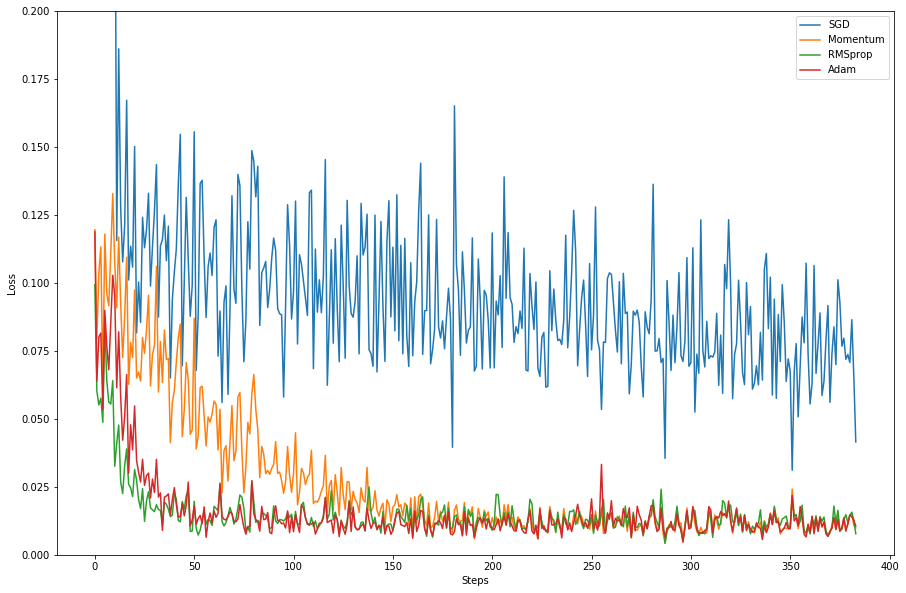

In [6]:
import torch
import torch.utils.data as Data
import torch.nn.functional as F
from torch.autograd import Variable
import matplotlib.pyplot as plt
%matplotlib inline

torch.manual_seed(1) # 设定随机数种子

# 定义超参数
LR = 0.01 # 学习率
BATCH_SIZE = 32 # 批大小
EPOCH = 12 # 迭代次数

x = torch.unsqueeze(torch.linspace(-1, 1, 1000), dim=1)
y = x.pow(2) + 0.1*torch.normal(torch.zeros(*x.size()))

#plt.scatter(x.numpy(), y.numpy())
#plt.show()

# 将数据转换为torch的dataset格式
torch_dataset = Data.TensorDataset(x, y)
# 将torch_dataset置入Dataloader中
loader = Data.DataLoader(dataset=torch_dataset, batch_size=BATCH_SIZE,
                         shuffle=True, num_workers=2)

class Net(torch.nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.hidden = torch.nn.Linear(1, 20)
        self.predict = torch.nn.Linear(20, 1)

    def forward(self, x):
        x = F.relu(self.hidden(x))
        x = self.predict(x)
        return x

# 为每个优化器创建一个Net
net_SGD = Net()
net_Momentum = Net()
net_RMSprop = Net()
net_Adam = Net()

nets = [net_SGD, net_Momentum, net_RMSprop, net_Adam]

# 初始化优化器
opt_SGD = torch.optim.SGD(net_SGD.parameters(), lr=LR)
opt_Momentum = torch.optim.SGD(net_Momentum.parameters(), lr=LR, momentum=0.8)
opt_RMSprop = torch.optim.RMSprop(net_RMSprop.parameters(), lr=LR, alpha=0.9)
opt_Adam = torch.optim.Adam(net_Adam.parameters(), lr=LR, betas=(0.9, 0.99))

optimizers = [opt_SGD, opt_Momentum, opt_RMSprop, opt_Adam]

# 定义损失函数
loss_function = torch.nn.MSELoss()
losses_history = [[], [], [], []] # 记录training时不同神经网络的loss值

for epoch in range(EPOCH):
    print('Epoch:', epoch + 1, 'Training...')
    for step, (batch_x, batch_y) in enumerate(loader):
        b_x = Variable(batch_x)
        b_y = Variable(batch_y)

        for net, opt, l_his in zip(nets, optimizers, losses_history):
            output = net(b_x)
            loss = loss_function(output, b_y)
            opt.zero_grad()
            loss.backward()
            opt.step()
            l_his.append(loss.item())

labels = ['SGD', 'Momentum', 'RMSprop', 'Adam']
plt.figure(facecolor='w', figsize=(15,10))
for i, l_his in enumerate(losses_history):
    plt.plot(l_his, label=labels[i])
plt.legend(loc='best')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.ylim((0, 0.2))
